In [ ]:
pip install kagglehub

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("minhnh2107/casiafasd")

print("Path to dataset files:", path)

100%|██████████| 70.6M/70.6M [00:00<00:00, 106MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/minhnh2107/casiafasd/versions/1


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from google.colab.patches import cv2_imshow

In [ ]:
dataset_path = path

In [ ]:
def preprocess_image(image_path, target_size=(64, 64)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize

    return img

In [ ]:
def load_data(data_folder):
    images = []
    labels = []
    for subfolder in ['color', 'depth']:  # Iterate through color and depth
        folder_path = os.path.join(data_folder, subfolder)
        for filename in os.listdir(folder_path):
            if filename.endswith('.jpg'):
                image_path = os.path.join(folder_path, filename)
                img = preprocess_image(image_path)
                images.append(img)

                # Extract label from filename
                if 'real' in filename:
                    labels.append(0)  # 0 for real
                elif 'fake' in filename:
                    labels.append(1)  # 1 for fake

    return np.array(images), np.array(labels)

In [ ]:
X_train, y_train = load_data(os.path.join(dataset_path, 'train_img/train_img'))
X_test, y_test = load_data(os.path.join(dataset_path, 'test_img/test_img'))

In [ ]:
print("Number of training images:", len(X_train))
print("Number of testing images:", len(X_test))

Number of training images: 3310
Number of testing images: 4816


In [ ]:
num_real_train = np.count_nonzero(y_train == 0)
num_fake_train = np.count_nonzero(y_train == 1)
num_real_test = np.count_nonzero(y_test == 0)
num_fake_test = np.count_nonzero(y_test == 1)

print("Training set - Real:", num_real_train, "Fake:", num_fake_train)
print("Testing set - Real:", num_real_test, "Fake:", num_fake_test)

Training set - Real: 808 Fake: 2502
Testing set - Real: 1182 Fake: 3634


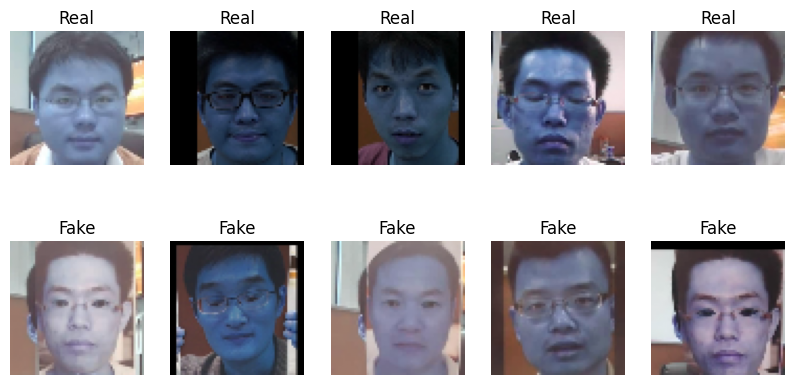

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[y_train == 0][i])
    plt.title("Real")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(X_train[y_train == 1][i])
    plt.title("Fake")
    plt.axis('off')

plt.show()

In [ ]:
!pip install vision_transformer_pytorch

**<h1>ViT</h1>**


In [ ]:
from vision_transformer_pytorch import VisionTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Split the training data into training and validation sets
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(
    X_train_tensor, y_train_tensor, test_size=0.2, random_state=42
)

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# Define the ViT model
image_size = 64
num_classes = 2
patch_size = 16

model = VisionTransformer.from_name(
    'ViT-B_16',
    image_size=image_size,
    num_classes=num_classes,
    patch_size=patch_size,
)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)  # Reduce LR if loss plateaus

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 20
best_val_loss = float('inf')
patience = 2 # Number of epochs to wait for improvement
epochs_without_improvement = 0

for epoch in range(epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        images = images.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculations during validation
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            val_images = val_images.permute(0, 3, 1, 2)
            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_labels).item()

    val_loss /= len(val_loader)  # Average validation loss
    scheduler.step(val_loss)  # Update scheduler based on validation loss
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.train()  # Set the model back to training mode

torch.save(model.state_dict(), 'vit_model.pth')
torch.save(optimizer.state_dict(), 'vit_optimizer.pth')

Epoch [1/20], Loss: 0.2533, Val Loss: 0.3636
Epoch [2/20], Loss: 0.3332, Val Loss: 0.3177
Epoch [3/20], Loss: 0.2669, Val Loss: 0.2811
Epoch [4/20], Loss: 0.2136, Val Loss: 0.3203
Epoch [5/20], Loss: 0.3682, Val Loss: 0.3104
Early stopping at epoch 5


In [ ]:
model.eval()  # Set the model to evaluation mode
all_predictions = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculations during testing
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        images = images.permute(0, 3, 1, 2)  # Reorder dimensions for DeiT
        outputs = model(images)

        # Get predicted probabilities for the positive class (e.g., class 1)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]

        # For accuracy calculation
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predictions.extend(probabilities.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Set a threshold (you might need to adjust this)
threshold = 0.5

# Separate predictions for genuine and imposter samples
genuine_predictions = all_predictions[all_labels == 1]  # Assuming 1 represents genuine
imposter_predictions = all_predictions[all_labels == 0]  # Assuming 0 represents imposter

# Calculate FAR and FRR
FAR = np.sum(imposter_predictions >= threshold) / len(imposter_predictions)
FRR = np.sum(genuine_predictions < threshold) / len(genuine_predictions)

# Calculate ACER
ACER = (FAR + FRR) / 2

print(f"FAR: {FAR:.4f}")
print(f"FRR: {FRR:.4f}")
print(f"ACER: {ACER:.4f}")

Test Accuracy: 88.10%
FAR: 0.4382
FRR: 0.0151
ACER: 0.2267


**<h1>DeiT</h1>**

In [ ]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import numpy as np

# assuming the image size of training data and test data is 64x64:
image_size = 64
patch_size = 8  # Reduced patch size

# Create image transform:
# Moved ToPILImage to the beginning of the transform pipeline
# and removed extra Resize operation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((image_size, image_size)),  # Resize to the desired size
    transforms.ToTensor(), # Convert the PIL Image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])


model = timm.create_model('deit_base_patch16_224', pretrained=True, num_classes=num_classes, img_size=image_size, patch_size=patch_size)

# Convert tensors to PIL images and apply transforms individually
X_train_transformed = []
for img in X_train_tensor:
    img = img.permute(2, 0, 1)
    X_train_transformed.append(transform(img))  # Apply transform to each image
X_train_transformed = torch.stack(X_train_transformed)  # Stack transformed images into a tensor

X_test_transformed = []
for img in X_test_tensor:
    img = img.permute(2, 0, 1)
    X_test_transformed.append(transform(img))  # Apply transform to each image
X_test_transformed = torch.stack(X_test_transformed)  # Stack transformed images into a tensor


train_dataset = TensorDataset(X_train_transformed, y_train_tensor)
test_dataset = TensorDataset(X_test_transformed, y_test_tensor)

In [ ]:
model = timm.create_model('deit_base_patch16_224', pretrained=True, num_classes=num_classes, img_size=image_size, patch_size=patch_size)

optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)  # Reduce LR if loss plateaus

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 20
best_val_loss = float('inf')
patience = 2 # Number of epochs to wait for improvement
epochs_without_improvement = 0

for epoch in range(epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        images = images.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculations during validation
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            val_images = val_images.permute(0, 3, 1, 2)
            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_labels).item()

    val_loss /= len(val_loader)  # Average validation loss
    scheduler.step(val_loss)  # Update scheduler based on validation loss
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.train()  # Set the model back to training mode
torch.save(model.state_dict(), 'DeiT_model.pth')
torch.save(optimizer.state_dict(), 'DeiT_optimizer.pth')


Epoch [1/20], Loss: 0.0278, Val Loss: 0.0227
Epoch [2/20], Loss: 0.0013, Val Loss: 0.0071
Epoch [3/20], Loss: 0.0009, Val Loss: 0.0053
Epoch [4/20], Loss: 0.0006, Val Loss: 0.0046
Epoch [5/20], Loss: 0.0005, Val Loss: 0.0043
Epoch [6/20], Loss: 0.0003, Val Loss: 0.0041
Epoch [7/20], Loss: 0.0001, Val Loss: 0.0041
Epoch [8/20], Loss: 0.0003, Val Loss: 0.0039
Epoch [9/20], Loss: 0.0001, Val Loss: 0.0038
Epoch [10/20], Loss: 0.0001, Val Loss: 0.0042
Epoch [11/20], Loss: 0.0001, Val Loss: 0.0040
Early stopping at epoch 11


In [ ]:
model.eval()  # Set the model to evaluation mode
all_predictions = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculations during testing
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        images = images.permute(0, 3, 1, 2)  # Reorder dimensions for DeiT
        outputs = model(images)

        # Get predicted probabilities for the positive class (e.g., class 1)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]

        # For accuracy calculation
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predictions.extend(probabilities.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

threshold = 0.5

# Separate predictions for genuine and imposter samples
genuine_predictions = all_predictions[all_labels == 1]  # Assuming 1 represents genuine
imposter_predictions = all_predictions[all_labels == 0]  # Assuming 0 represents imposter

# Calculate FAR and FRR
FAR = np.sum(imposter_predictions >= threshold) / len(imposter_predictions)
FRR = np.sum(genuine_predictions < threshold) / len(genuine_predictions)

# Calculate ACER
ACER = (FAR + FRR) / 2

print(f"FAR: {FAR:.4f}")
print(f"FRR: {FRR:.4f}")
print(f"ACER: {ACER:.4f}")

Test Accuracy: 98.46%
FAR: 0.0482
FRR: 0.0047
ACER: 0.0265
